In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import hvplot.pandas
from scipy.stats import linregress
from sklearn.preprocessing import LabelEncoder


ca_housing_path = "Resources/CA_Housing_Data.csv"

ca_housing_data = pd.read_csv(ca_housing_path)

ca_housing_data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


In [45]:
Near_Bay_Pop = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == "NEAR BAY", "population"].mean()
Inland_Pop = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == "INLAND", "population"].mean()
Under_Hour_Pop = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == "<1H OCEAN", "population"].mean()
Near_Ocean_Pop = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == "NEAR OCEAN", "population"].mean()
Island_pop = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == "ISLAND", "population"].mean()

print(Near_Ocean_Pop)
print(Near_Bay_Pop)
print(Inland_Pop)
print(Under_Hour_Pop)
print(Island_pop)

1354.0086531226486
1230.3174672489083
1391.0462524805373
1520.2904991243433
668.0


In [47]:
# Put proximities into a list for for loop (and later for plot labels)
Ocean_Proximity = ["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]
Ocean_Proximity

# Create empty list to fill with population data (for plotting)
population_data= []

# Calculate the IQR and quantitatively determine if there are any potential outliers.
for proximity in Ocean_Proximity:

     # Locate the rows which contain the population data for each category of ocean proximity
    Population = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == proximity, "population"]
    
    quartiles = Population.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq

    # add subset
    population_data.append(Population)

    # Determine outliers using upper and lower bounds
    
    upper_bound = upperq + (1.5*iqr)
    lower_bound = lowerq - (1.5*iqr)

    outliers_population = Population[(Population < lower_bound) | (Population > upper_bound)]


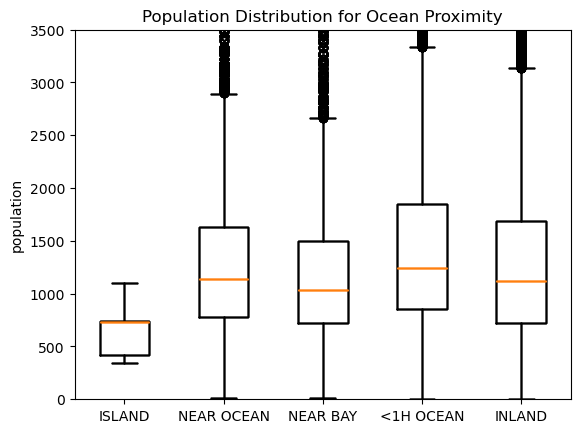

In [48]:
# Generate a box plot that shows the distribution of the tumor volume for each treatment group.
fig1, ax1 = plt.subplots()

ax1.set_ylabel('population')

for proximity in Ocean_Proximity:
    ax1.boxplot(population_data)

ax1.set_xticks([1, 2, 3, 4, 5])
ax1.set_xticklabels(Ocean_Proximity)
plt.ylim(0, 3500)
plt.title('Population Distribution for Ocean Proximity')
plt.show()

The r^2-value is: 0.0049395992150810695


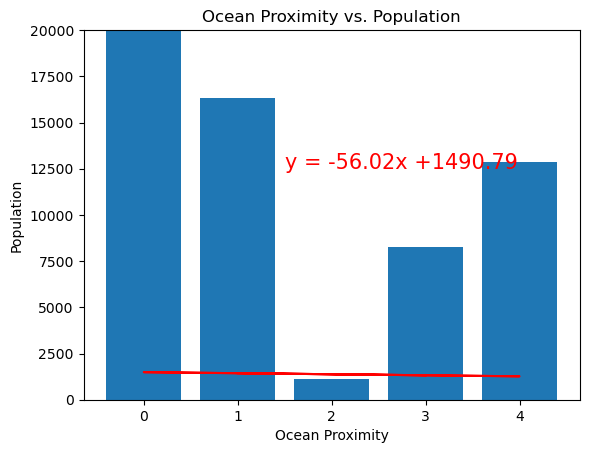

In [56]:

label_encoder = LabelEncoder()
ca_housing_data['Ocean_Proximity_Encoded'] = label_encoder.fit_transform(ca_housing_data['ocean_proximity'])

x_values = ca_housing_data["Ocean_Proximity_Encoded"]
y_values = ca_housing_data["population"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = slope * x_values + intercept

line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.bar(x_values,y_values)
plt.plot(x_values,regress_values,"r-") 

# Label plot and annotate the line equation
plt.xlabel('Ocean Proximity')
plt.ylabel('Population')
plt.annotate(line_eq,(1.5,12500),fontsize=15,color="red")
plt.ylim(0, 20000) 
plt.title(f"Ocean Proximity vs. Population")

# Print r^2 value
print(f"The r^2-value is: {rvalue**2}")

# Show plot
plt.show()